In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import os

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

In [2]:
from sklearn import preprocessing

Benjamin: cumulative_enrollment, stats_sd

Andrew: pubschools_info

Alex: border_crossings

In [3]:
border_crossings_path = os.path.join('Datasets', 'border_crossings.csv')
border_crossings = pd.read_csv(border_crossings_path, low_memory=False)

cumulative_enrollment_path = os.path.join('Datasets', 'cumulative_enrollment.csv')
cumulative_enrollment = pd.read_csv(cumulative_enrollment_path, low_memory=False)

pubschools_info_path = os.path.join('Datasets', 'pubschools_info.csv')
pubschools_info = pd.read_csv(pubschools_info_path, low_memory=False)

stats_sd_path = os.path.join('Datasets', 'COVID_19_Statistics_San_Diego_County.csv')
stats_sd = pd.read_csv(stats_sd_path, low_memory=False)

#I'm having a bit of trouble loading this one in for some reason, I'll check it out later.
#age_stats_sd_path = os.path.join('Datasets', 'COVID-19_Age_Statistics_by_ZIP_Code')
#age_stats_sd = pd.read_csv(age_stats_sd_path, low_memory=False)

### Checklist:
    1. Get dtypes in order
        change dates to object datetime
        natural numbers to int
        decimals to float
    2. Remove columns that are not relevant
    3. Remove the unneeded symbols from string data
    4. Replace null/blank/missing values with NaN
    5. Look for and understand suspicious or out of place values for each column
    6. Fill missing values or drop them as needed (for this one we can discuss among us which is the best method to deal with 
       missingness for each dataset, as there are a lot of ways to do them.
                                        

### Cumulative Enrollment

In [4]:
#Removed insignificant columns
#Changed all * values (missing for student privacy) to NaN, rest of CumulativeEnrollment to float.
cumulative_clean = cumulative_enrollment.drop(["AcademicYear", "CountyCode", "DistrictCode", "SchoolCode"], axis=1) #Dropped codes
cumulative_clean["CumulativeEnrollment"] = pd.to_numeric(cumulative_clean["CumulativeEnrollment"], errors='coerce')

In [5]:
cumulative_clean["School, District"] = cumulative_clean["SchoolName"] + ", " + cumulative_clean["DistrictName"]

In [6]:
cumulative_clean

,AggregateLevel,CountyName,DistrictName,SchoolName,Charter,ReportingCategory,CumulativeEnrollment,"School, District"
0,S,Orange,Saddleback Valley Unified,Portola Hills Elementary,All,RA,90.0,"Portola Hills Elementary, Saddleback Valley Un..."
1,S,Orange,Saddleback Valley Unified,Portola Hills Elementary,All,RB,NaN,"Portola Hills Elementary, Saddleback Valley Un..."
2,S,Orange,Saddleback Valley Unified,Portola Hills Elementary,All,RD,NaN,"Portola Hills Elementary, Saddleback Valley Un..."
3,S,Orange,Saddleback Valley Unified,Portola Hills Elementary,All,RF,18.0,"Portola Hills Elementary, Saddleback Valley Un..."
4,S,Orange,Saddleback Valley Unified,Portola Hills Elementary,All,RH,110.0,"Portola Hills Elementary, Saddleback Valley Un..."
...,...,...,...,...,...,...,...,...
355142,C,Imperial,NaN,NaN,No,TA,38536.0,NaN
355143,C,San Mateo,NaN,NaN,No,TA,88986.0,NaN
355144,C,Santa Barbara,NaN,NaN,No,TA,66537.0,NaN
355145,C,Kern,NaN,NaN,No,TA,183911.0,NaN


### COVID-19 Stats in San Diego 

In [7]:
stats_sd["date"] = pd.to_datetime(stats_sd["date"])

### Border Crossing

In [8]:
months = ["January", "February", "March", "April", "May", "June", "July"]
border = pd.read_csv("Datasets/border_crossings.csv")
#Dropped nans
border = border.dropna(axis=0)
for month in months:
    border[month] = border[month].str.replace(',', '').astype(int)

### Public Schools

In [9]:
schools = pd.read_csv('Datasets/pubschools_info.csv')

schools = schools.loc[schools['County'] == 'San Diego']

cols_to_drop = ["NCESDist","NCESSchool","StreetAbr","MailStreet","MailStrAbr","MailCity",
               "MailZip","MailState","Ext","FaxNumber","Email","Phone","CharterNum",
                "FundingType","DOC","DOCType","EdOpsCode","EdOpsName","Magnet","FederalDFCDistrictID",
                "AdmFName","AdmLName","AdmEmail","YearRoundYN",'State', 
                'OpenDate',"SOC", "SOCType","GSoffered","GSserved",'ClosedDate']

schools = schools.drop(cols_to_drop, axis=1)

c:\users\administrator\appdata\local\programs\python\python38-32\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [10]:
clean1 = schools.loc[schools['StatusType'] == 'Active'] #Keeps only active schools
clean3 = clean1.loc[clean1['School'] != 'No Data'] #drops district records - nonschools
clean3['LastUpDate'] = pd.to_datetime(clean3['LastUpDate']) #change lastUpDate to datetime obj col
clean3 = clean3.reset_index().drop('index',axis = 1)
schools = clean3

schools = schools.replace("No Data",np.nan) #changed "No Data" into NaNs
schools['Latitude'] = schools['Latitude'].astype(float) #changed latitutde to float dtype
schools['Longitude'] = schools['Longitude'].astype(float) #changed longitude to float dtype
schools = schools.drop(['StatusType','County'],axis = 1) #dropped statustype and county col since its all active and SD county

# small_zip = schools['Zip'].str.slice(0,5).astype(float)
# schools = schools.assign(SmallZip=small_zip)

<ipython-input-10-f996a1a30d22>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean3['LastUpDate'] = pd.to_datetime(clean3['LastUpDate']) #change lastUpDate to datetime obj col


In [11]:
address = schools['Street'] + ',' + schools['City'] + ",CA," + schools['Zip'].str.slice(0,5)
schools = schools.assign(Address = address).drop(["Street",'City'],axis = 1)
schools = schools.assign(Zipcode = schools['Zip'].str.slice(0,5))
schools['Zipcode'] = schools['Zipcode'].astype(int)

In [12]:
schools = schools.drop(columns=["Virtual"], axis=1)

In [13]:
type_of_schools = ['ELEM','HS','INTMIDJR','ELEMHIGH']
schools = schools[schools.EILCode.isin(type_of_schools)]

schools = schools.loc[schools['Charter'] == 'N']
schools = schools.drop(['EILCode','Charter'],axis = 1)


In [14]:
num_schools = len(schools)
unique_small_zips = schools['Zipcode'].nunique()
unique_zips = len(schools['Zip'].unique())
total_zips = len(schools['Zip'])

In [15]:
print("There are {} unique Zipcodes out of {}".format(unique_small_zips, total_zips))
print("There are {} unique Zips out of {}.".format(unique_zips,total_zips))

There are 90 unique Zipcodes out of 634
There are 577 unique Zips out of 634.


In [16]:
schools["School, District"] = schools["School"] + ", " + schools["District"]

In [17]:
schools

,CDSCode,District,School,Zip,WebSite,EILName,Latitude,Longitude,LastUpDate,Address,Zipcode,"School, District"
1,37103710115998,San Diego County Office of Education,San Pasqual Academy,92025-5301,http://www.sanpasqualacademy.org,High School,33.090580,-116.95009,2019-02-13,"17701 San Pasqual Valley Road,Escondido,CA,92025",92025,"San Pasqual Academy, San Diego County Office o..."
2,37103710120485,San Diego County Office of Education,Davila Day,91910-3604,NaN,Elementary,32.635041,-117.08832,2019-02-13,"540 G Street,Chula Vista,CA,91910",91910,"Davila Day, San Diego County Office of Education"
3,37103710120493,San Diego County Office of Education,Monarch,92113-1012,http://www.monarchschools.org,Elementary-High Combination,32.702375,-117.15045,2020-08-24,"1625 Newton Avenue,San Diego,CA,92113",92113,"Monarch, San Diego County Office of Education"
4,37103710128520,San Diego County Office of Education,San Diego County Community,92111-7399,http://www.sdcoe.net,Elementary-High Combination,32.769578,-117.17984,2020-08-21,"6401 Linda Vista Road, Room 216,San Diego,CA,9...",92111,"San Diego County Community, San Diego County O..."
5,37103710128538,San Diego County Office of Education,San Diego County Court,92123,http://www.sdcoe.net/jccs,High School,32.794147,-117.15396,2019-02-13,"2801 Meadow Lark Drive,San Diego,CA,92123",92123,"San Diego County Court, San Diego County Offic..."
...,...,...,...,...,...,...,...,...,...,...,...,...
769,37756146112494,Valley Center-Pauma Unified,Valley Center Elementary,92082-6575,http://vceus.vcpusd.org,Elementary,33.234769,-117.02397,2019-08-21,"28751 Cole Grade Road,Valley Center,CA,92082",92082,"Valley Center Elementary, Valley Center-Pauma ..."
779,37768510110122,Bonsall Unified,Bonsall West Elementary,92057-2704,http://www.bonsallusd.com,Elementary,33.263619,-117.29384,2020-08-13,"5050 El Mirlo Drive,Oceanside,CA,92057",92057,"Bonsall West Elementary, Bonsall Unified"
780,37768510129320,Bonsall Unified,Bonsall High,92003-4316,http://www.bonsallhs.com,High School,33.296238,-117.17648,2020-08-13,"7350 West Lilac Road,Bonsall,CA,92003",92003,"Bonsall High, Bonsall Unified"
781,37768516037543,Bonsall Unified,Bonsall Elementary,92003-5112,http://www.bonsallusd.com,Elementary,33.287143,-117.22078,2020-08-13,"31555 Old River Road,Bonsall,CA,92003",92003,"Bonsall Elementary, Bonsall Unified"


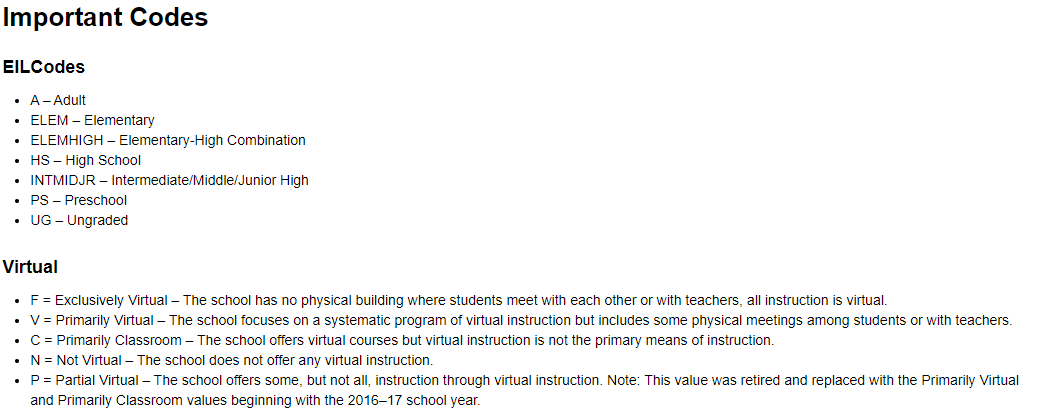

### Incomes

In [18]:
incomes_path = os.path.join('Datasets', 'suave_income.csv')
incomes = pd.read_csv(incomes_path, low_memory=False)

In [19]:
incomes_classes = incomes[["ZIP", 
         "Hholds with income Less than $10,000#number", 
         'Hholds with income $10,000 to $14,999#number',
         'Hholds with income $15,000 to $24,999#number',
         'Hholds with income $25,000 to $34,999#number',
         'Hholds with income $35,000 to $49,999#number',
         'Hholds with income $50,000 to $74,999#number',
         'Hholds with income $75,000 to $99,999#number',
         'Hholds with income $100,000 to $149,999#number',
         'Hholds with income $150,000 to $199,999#number',
         'Hholds with income $200,000 or more#number',
         'Median family income (dollars)#number',
         'Mean family income (dollars)#number',
         'Health insurance coverage, % of civilian pop#number',
         'No health insurance for civil pop#number',
         'No health insurance coverage, %#number',
         'Worked at home#number', 'Population 16+yo#number', 'Children of the hh 6-17 yo#number'
         ]]
incomes_clean = incomes_classes.copy()
incomes_clean["Households with income $0-34,999"] = (incomes_classes["Hholds with income Less than $10,000#number"] 
                                               + incomes_classes["Hholds with income $10,000 to $14,999#number"] 
                                               + incomes_classes["Hholds with income $15,000 to $24,999#number"] 
                                               + incomes_classes["Hholds with income $25,000 to $34,999#number"]
                                              )
incomes_clean["Households with income $35,000-99,999"] = (incomes_classes["Hholds with income $35,000 to $49,999#number"] 
                                               + incomes_classes["Hholds with income $50,000 to $74,999#number"] 
                                               + incomes_classes["Hholds with income $75,000 to $99,999#number"] 
                                              )
incomes_clean["Households with income $100,000+"] = (incomes_classes["Hholds with income $100,000 to $149,999#number"] 
                                               + incomes_classes["Hholds with income $150,000 to $199,999#number"]
                                               + incomes_classes["Hholds with income $200,000 or more#number"] 
                                              ) 
incomes_clean = incomes_clean.drop(["Hholds with income Less than $10,000#number", 
         'Hholds with income $10,000 to $14,999#number',
         'Hholds with income $15,000 to $24,999#number',
         'Hholds with income $25,000 to $34,999#number',
         'Hholds with income $35,000 to $49,999#number',
         'Hholds with income $50,000 to $74,999#number',
         'Hholds with income $75,000 to $99,999#number',
         'Hholds with income $100,000 to $149,999#number',
         'Hholds with income $150,000 to $199,999#number',
         'Hholds with income $200,000 or more#number',], axis=1)
incomes_clean = incomes_clean.rename(columns={'Median family income (dollars)#number': 'Median family income (dollars)',
                                             'Mean family income (dollars)#number' :'Mean family income (dollars)',
                                             'Health insurance coverage, % of civilian pop#number':'Health insurance coverage, % of civilian pop',
                                             'No health insurance for civil pop#number': 'No health insurance for civilian pop',
                                             'No health insurance coverage, %#number': 'No health insurance coverage %',
                                             'Worked at home#number': 'Worked at home',
                                             'ZIP': 'Zipcode', 'Population 16+yo#number':'Population 16+', 
                                             'Children of the hh 6-17 yo#number': 'Children of the household 6-17'})


In [20]:
pop = incomes_clean[["Zipcode", "Population 16+"]]

### Cleaned Demographics Data

In [21]:
cleaned_demo_path = os.path.join('Datasets', 'Cleaned_Demographics_Data.csv')
cleaned_demo = pd.read_csv(cleaned_demo_path, low_memory=False)


### Cleaned Cases by Zipcode

In [22]:
cleaned_cases_path = os.path.join('Datasets', 'Cleaned_Cases_by_Zipcode.csv')
cleaned_cases = pd.read_csv(cleaned_cases_path, low_memory=False)
#cleaned_cases = cleaned_cases.rename(columns={'Zipcode': 'Zip'})


### August Cases Increase

In [23]:
august_cases_path = os.path.join('Datasets', 'August_Case_Increase.csv')
august_cases = pd.read_csv(august_cases_path, low_memory=False)

In [24]:
august_cases = august_cases[["Zipcode", "Absolute Increase", "Percent Increase"]]

In [25]:
august_cases = august_cases.merge(pop, on="Zipcode")

In [26]:
august_cases["Absolute Increase Standardized"] = august_cases["Absolute Increase"] / august_cases["Population 16+"]

In [27]:
august_cases = august_cases.drop(["Absolute Increase", "Population 16+"], axis=1)

In [28]:
august_cases

,Zipcode,Percent Increase,Absolute Increase Standardized
0,91901,23.08,0.001211
1,91902,31.36,0.003275
2,91905,16.67,0.000711
3,91906,18.75,0.001093
4,91910,31.97,0.006362
...,...,...,...
99,92140,41.27,0.007834
100,92145,14.29,0.000643
101,92154,28.95,0.007578
102,92173,34.09,0.014020


# Data Exploration

In [29]:
zips = schools["Zipcode"].unique()

In [30]:
cumulative_clean = cumulative_clean[cumulative_clean["AggregateLevel"] == "S"]

In [31]:
cumulative_clean = cumulative_clean[cumulative_clean["CountyName"] == "San Diego"]
cumulative_clean = cumulative_clean.rename(columns={'SchoolName': "School"})
cumulative_clean = cumulative_clean[cumulative_clean["ReportingCategory"] == "TA"]

In [32]:
cumulative_clean = cumulative_clean[cumulative_clean["Charter"] == "No "]

In [33]:
cumulative_clean = cumulative_clean.drop(["Charter"], axis=1)

In [34]:
merged = schools.merge(cumulative_clean, on="School, District")

In [35]:
done = merged.merge(incomes_clean, on="Zipcode")

In [36]:
done = done.merge(august_cases, on="Zipcode")

In [37]:
done_shorter = done.drop(columns=["AggregateLevel", "CountyName", "CDSCode", 
                                  "Zip", "WebSite", "ReportingCategory", 
                                  "LastUpDate", "School_x", "School_y", "District"], axis=1)

In [38]:
#Impute value for median family income for zip 91905 with that of 91906
done_shorter.loc[319, "Median family income (dollars)"] = 60240.0

In [39]:
from sklearn.cluster import KMeans
import sklearn.preprocessing as pp

In [81]:
# Numeric columns and associated transformers
num_feat = [
    'CumulativeEnrollment', 
    'Median family income (dollars)', 
    'Mean family income (dollars)', 
    "Health insurance coverage, % of civilian pop", 
    "No health insurance for civilian pop", 
    "No health insurance coverage %", 
    "Worked at home", 
    "Households with income $0-34,999", 
    "Households with income $35,000-99,999", 
    "Households with income $100,000+",
    "Population 16+",
    "Children of the household 6-17",
    "Absolute Increase Standardized",
    "Percent Increase"
]
num_transformer = Pipeline(steps=[
    ('scaler', pp.StandardScaler())   # z-scale
])

# Categorical columns and associated transformers
cat_feat = ['EILName', 'Zipcode']
cat_transformer = Pipeline(steps=[
    ('intenc', pp.OrdinalEncoder()),   # converts to int
    ('onehot', pp.OneHotEncoder())     # output from Ordinal becomes input to OneHot
])

# preprocessing pipeline (put them together)
preproc = ColumnTransformer(transformers=[('num', num_transformer, num_feat), ('cat', cat_transformer, cat_feat)])

pl = Pipeline(steps=[('preprocessor', preproc), ('kmeans', KMeans(n_clusters=3, n_init=1000))])

In [82]:
pl.fit(done_shorter)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['CumulativeEnrollment',
                                                   'Median family income '
                                                   '(dollars)',
                                                   'Mean family income '
                                                   '(dollars)',
                                                   'Health insurance coverage, '
                                                   '% of civilian pop',
                                                   'No health insurance for '
                                                   'civilian pop',
                                                   'No health insurance '
                      

In [83]:
predictions = pl.predict(done_shorter)

In [84]:
done_shorter["predictions"] = predictions

In [104]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["CumulativeEnrollment"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["CumulativeEnrollment"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["CumulativeEnrollment"]))

0: 952.4489795918367
1: 607.9839572192514
2: 713.2429577464789


In [105]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["Population 16+"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["Population 16+"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["Population 16+"]))

0: 40134.02721088436
1: 21571.673796791445
2: 47971.60211267605


In [106]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["Children of the household 6-17"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["Children of the household 6-17"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["Children of the household 6-17"]))

0: 7611.040816326531
1: 3579.5882352941176
2: 8840.61971830986


In [107]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["No health insurance for civilian pop"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["No health insurance for civilian pop"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["No health insurance for civilian pop"]))

0: 2836.408163265306
1: 2155.6791443850266
2: 8355.401408450703


In [108]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["Mean family income (dollars)"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["Mean family income (dollars)"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["Mean family income (dollars)"]))

0: 147795.9863945578
1: 109642.04278074867
2: 79647.69366197183


In [109]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["Worked at home"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["Worked at home"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["Worked at home"]))

0: 2138.3061224489797
1: 898.283422459893
2: 1357.1971830985915


In [110]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["Households with income $0-34,999"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["Households with income $0-34,999"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["Households with income $0-34,999"]))

0: 952.4489795918367
1: 607.9839572192514
2: 713.2429577464789


In [111]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["Households with income $35,000-99,999"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["Households with income $35,000-99,999"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["Households with income $35,000-99,999"]))

0: 6172.374149659864
1: 4079.812834224599
2: 8326.13028169014


In [112]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["Households with income $100,000+"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["Households with income $100,000+"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["Households with income $100,000+"]))

0: 8792.238095238095
1: 3330.4010695187167
2: 4465.221830985915


In [113]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["Percent Increase"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["Percent Increase"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["Percent Increase"]))

0: 27.298163265306123
1: 33.66032085561497
2: 34.022781690140846


In [114]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["Absolute Increase Standardized"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["Absolute Increase Standardized"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["Absolute Increase Standardized"]))

0: 0.001780235209763654
1: 0.0024767789017717916
2: 0.004921286285262089


In [ ]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["CumulativeEnrollment"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["CumulativeEnrollment"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["CumulativeEnrollment"]))

In [ ]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["CumulativeEnrollment"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["CumulativeEnrollment"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["CumulativeEnrollment"]))

In [ ]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["CumulativeEnrollment"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["CumulativeEnrollment"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["CumulativeEnrollment"]))

In [102]:
done_shorter.columns

Index(['EILName', 'Latitude', 'Longitude', 'Address', 'Zipcode',
       'School, District', 'DistrictName', 'CumulativeEnrollment',
       'Median family income (dollars)', 'Mean family income (dollars)',
       'Health insurance coverage, % of civilian pop',
       'No health insurance for civilian pop',
       'No health insurance coverage %', 'Worked at home', 'Population 16+',
       'Children of the household 6-17', 'Households with income $0-34,999',
       'Households with income $35,000-99,999',
       'Households with income $100,000+', 'Percent Increase',
       'Absolute Increase Standardized', 'predictions'],
      dtype='object')

0 is more at risk, 
1 is less at risk

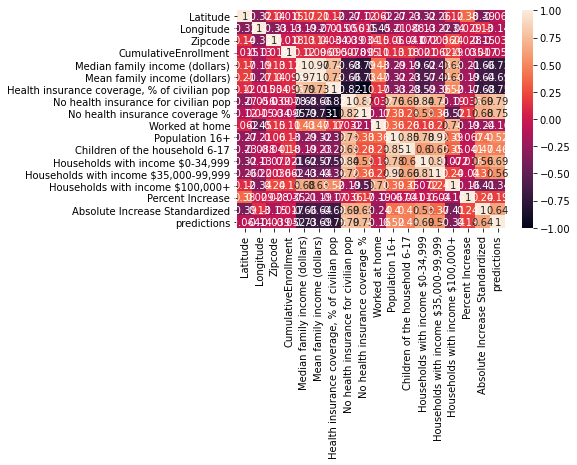

In [47]:
import seaborn as sns 
  
# generating correlation heatmap 
sns.heatmap(done_shorter.corr(), annot = True) 

In [48]:
done_shorter.to_csv(r'C:/Users/Administrator/Data Challenge/border_chlng/Datasets/schools_data.csv')